In [1]:
import torch
import torchvision
from sklearn.datasets import make_circles

In [2]:
# Make 1000 samples 
n_samples = 5000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.02, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[-0.76928899 -0.57253359]
 [ 0.78695815  0.14302339]
 [ 0.74562001  0.3043983 ]
 [-0.88626403  0.48336329]
 [-0.17727187  0.96348697]]

First 5 y labels:
[0 1 1 0 0]


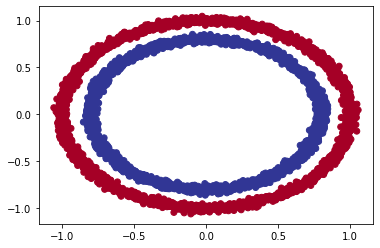

In [4]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [5]:
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.transforms import transforms

In [6]:
len(X)

5000

### Data split

In [7]:
## Split the data
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(Y_train), len(Y_test)

(4000, 1000, 4000, 1000)

In [8]:
x_train, val_train, y_train, val_test = train_test_split(X_train, 
                                                    Y_train, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(x_train), len(y_train), len(val_train), len(val_test)

(3200, 3200, 800, 800)

### TensorDataset

In [9]:
x_train = torch.from_numpy(x_train)
x_train = x_train.type(torch.float32)
y_train = torch.from_numpy(y_train)
y_train = y_train.type(torch.float32)
x_train.dtype, y_train.dtype

(torch.float32, torch.float32)

In [10]:
val_train = torch.from_numpy(val_train)
val_train = val_train.type(torch.float32)
val_test = torch.from_numpy(val_test)
val_test = val_test.type(torch.float32)
val_train.dtype, val_test.dtype

(torch.float32, torch.float32)

In [11]:
x_test = torch.from_numpy(X_test)
x_test = x_test.type(torch.float32)
y_test = torch.from_numpy(Y_test)
y_test = y_test.type(torch.float32)
x_test.dtype, y_test.dtype

(torch.float32, torch.float32)

In [12]:
train_ds = TensorDataset(x_train, y_train)

In [13]:
valid_ds = TensorDataset(val_train, val_test)

In [14]:
test_ds = TensorDataset(x_test, y_test)

In [15]:
train_ds[0]

(tensor([-0.7891,  0.0607]), tensor(1.))

### Dataloader

In [16]:
batch_size = 64
train_dl = DataLoader(dataset = train_ds, batch_size=batch_size, shuffle=True)
train_dl

In [17]:
valid_dl = DataLoader(dataset = valid_ds, batch_size=32)
valid_dl

In [18]:
test_dl = DataLoader(dataset = test_ds, batch_size=32)
test_dl

### Test

In [19]:
import torch.nn as nn

In [20]:
x_train.shape, y_train.shape

(torch.Size([3200, 2]), torch.Size([3200]))

In [21]:
model = nn.Linear(in_features=2, out_features=1)
model

Linear(in_features=2, out_features=1, bias=True)

In [22]:
model.state_dict()

OrderedDict([('weight', tensor([[0.6628, 0.0151]])),
             ('bias', tensor([-0.6446]))])

In [23]:
for xb, yb in train_dl:
    print(xb.shape)
    out = model(xb)
    print(out.shape)
    break

torch.Size([64, 2])
torch.Size([64, 1])


In [24]:
logits = model(xb)
preds = torch.round(torch.sigmoid(logits)).squeeze()
preds.shape

torch.Size([64])

In [25]:
preds[:5]

tensor([0., 0., 0., 1., 0.], grad_fn=<SliceBackward0>)

In [26]:
yb[:5]

tensor([0., 0., 1., 0., 0.])

In [27]:
loss_fn = nn.BCEWithLogitsLoss()

In [28]:
loss = loss_fn(preds, yb)
loss

tensor(0.7125, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [29]:
def accuracy(preds, labels):
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [30]:
accuracy(preds,yb)

tensor(0.5156)

### Custom model

In [31]:
def fit(epochs, lr, model, train_dl, valid_dl, opt_func = torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr=lr)
    history = []
    
    for epoch in range(epochs):
        for batch in train_dl:
            model.train()
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        model.eval()
        with torch.inference_mode():
            result = evaluate(model, valid_dl)
            model.epoch_end(epoch, result)
            history.append(result)
    return history

In [32]:
def evaluate(model, valid_dl):
    valid_pred = [model.validation_step(batch) for batch in valid_dl]
    return model.validation_epoch_end(valid_pred)

In [41]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=1)
        # self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, xb):
        xb = self.layer_2(self.relu(self.layer_1(xb)))
        return xb
    
    def training_step(self, batch):
        samples, labels = batch
        logits = self(samples)
        preds = torch.round(torch.sigmoid(logits)).squeeze()
        loss = loss_fn(logits.squeeze(), labels)
        return loss
    
    def validation_step(self, batch):
        samples, labels = batch
        logits = self(samples)
        preds = torch.round(torch.sigmoid(logits)).squeeze()
        loss = loss_fn(logits.squeeze(), labels)
        acc = accuracy(preds, labels)
        return {"val_loss": loss, "val_acc": acc}
        
    def validation_epoch_end(self, val_pred):
        batch_loss = [x['val_loss'] for x in val_pred]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in val_pred]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoch_loss, 'val_acc': epoch_acc}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}] | valid_loss: {:.4f} | valid_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [42]:
model = LogisticRegression()
model

LogisticRegression(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [43]:
result0 = evaluate(model, valid_dl)
result0

{'val_loss': tensor(0.7004, grad_fn=<MeanBackward0>),
 'val_acc': tensor(0.5150)}

In [44]:
history1 = fit(75, 0.1, model, train_dl, valid_dl)

Epoch [0] | valid_loss: 0.6977 | valid_acc: 0.5150
Epoch [1] | valid_loss: 0.6957 | valid_acc: 0.4575
Epoch [2] | valid_loss: 0.6938 | valid_acc: 0.5150
Epoch [3] | valid_loss: 0.6921 | valid_acc: 0.4825
Epoch [4] | valid_loss: 0.6905 | valid_acc: 0.5650
Epoch [5] | valid_loss: 0.6888 | valid_acc: 0.5200
Epoch [6] | valid_loss: 0.6877 | valid_acc: 0.6112
Epoch [7] | valid_loss: 0.6857 | valid_acc: 0.5700
Epoch [8] | valid_loss: 0.6842 | valid_acc: 0.5863
Epoch [9] | valid_loss: 0.6820 | valid_acc: 0.5813
Epoch [10] | valid_loss: 0.6795 | valid_acc: 0.5688
Epoch [11] | valid_loss: 0.6773 | valid_acc: 0.5875
Epoch [12] | valid_loss: 0.6746 | valid_acc: 0.5938
Epoch [13] | valid_loss: 0.6720 | valid_acc: 0.5925
Epoch [14] | valid_loss: 0.6692 | valid_acc: 0.5975
Epoch [15] | valid_loss: 0.6662 | valid_acc: 0.6012
Epoch [16] | valid_loss: 0.6631 | valid_acc: 0.6425
Epoch [17] | valid_loss: 0.6591 | valid_acc: 0.6338
Epoch [18] | valid_loss: 0.6548 | valid_acc: 0.6187
Epoch [19] | valid_los

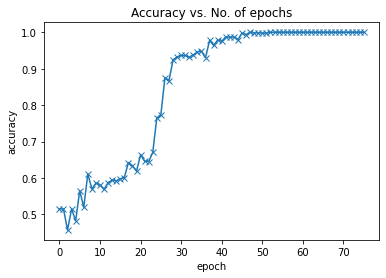

In [45]:
history = [result0] + history1
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [46]:
# Make predictions
model.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model(x_test))).squeeze()
y_preds[:10], y_test[:10] # want preds in same format as truth labels

(tensor([0., 0., 0., 1., 1., 0., 1., 1., 0., 1.]),
 tensor([0., 0., 0., 1., 1., 0., 1., 1., 0., 1.]))

In [47]:
test_accuracy = accuracy(y_preds,y_test)
test_accuracy

tensor(0.9990)

In [48]:
from helper_functions import plot_decision_boundary

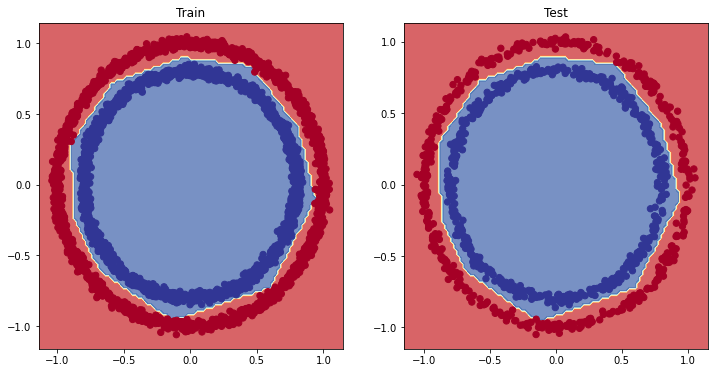

In [49]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, x_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, x_test, y_test) # model_3 = has non-linearity